In [130]:
import json
from collections import Counter
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import ssl
import numpy as np 
import seaborn as sns
import random
ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer 
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/volthai7us/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [131]:
def clean_and_split(text):
    words = re.findall(r'\b\w+\b', text.lower())
    return words

def preprocess_speaker(speaker): 
    file_path = f'./data/transcripts/friends-1-227-{speaker}-pair.json'

    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        
        
    all_answers = [item['answer'] for item in data]

    all_answers = [clean_and_split(answer) for answer in all_answers]

    stop_words = set(stopwords.words('english'))
    
    
    def remove_stopwords(answer):
        filtered_words = [word for word in answer if word.lower() not in stop_words]
        return ' '.join(filtered_words)

    all_answers = [remove_stopwords(answer) for answer in all_answers]

    return all_answers

In [132]:
speakers = ("Rachel", "Chandler", "Phoebe", "Monica", "Ross", "Joey")

all_data = []

for index, speaker in enumerate(speakers):
    all_answers = preprocess_speaker(speaker=speaker)
    speaker_data = [(answer, index) for answer in all_answers]
    sample_size = min(5000, len(speaker_data))
    random_sample = random.sample(speaker_data, sample_size)
    all_data.extend(random_sample)
    
speaker_combinations = []

for speaker1 in speakers:
    for speaker2 in speakers:
        combination = f"{speaker1}-{speaker2}"
        speaker_combinations.append(combination)

df = pd.DataFrame(all_data, columns=['text', 'speaker'])
df = df.sample(frac=1)

In [133]:
# rachel_df = df[df['speaker'] == 0]
# other_df = df[df['speaker'] != 0]
# other_df = other_df.sample(frac=1)
# other_df = other_df[:rachel_df.shape[0]]
# other_df['speaker'] = 1
# df = pd.concat([rachel_df, other_df])
# df = df.sample(frac=1)
# speakers = ["Rachel", "Other"]

In [134]:
docs = list(df['text'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
tfidf_vectorizer = tfidf_vectorizer.fit(docs)
tfidf_vectorizer_vectors = tfidf_vectorizer.transform(docs)
docs = tfidf_vectorizer_vectors.toarray()

In [135]:
X = docs 
y = df['speaker']
print(X.shape, y.shape)

(25770, 9646) (25770,)


In [136]:
fig = go.Figure([go.Bar(x=y.value_counts().index, y=y.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

In [137]:
def train_and_test(X, y, model=GaussianNB):
    print("-" * 50)
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

    m = model
    # print("Model: ", model.__name__)
    %time m.fit(X_train, y_train)

    y_pred_train = m.predict(X_train)
    y_pred_test = m.predict(X_test)
    print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
    print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
    
    print(classification_report(y_test, y_pred_test, target_names=speakers))
    
    cm = confusion_matrix(y_test, y_pred_test, normalize='true')
    # print('Confusion matrix\n', cm)

    cm_matrix = pd.DataFrame(data=cm, columns=speakers, index=speakers)
    sns.heatmap(cm_matrix, annot=True , cmap='YlGnBu')
    plt.show()
    
    return m

In [138]:
from sklearn.neural_network import MLPClassifier

--------------------------------------------------
CPU times: user 672 ms, sys: 234 ms, total: 906 ms
Wall time: 1.08 s

Training Accuracy score: 0.6054520760574311
Testing Accuracy score: 0.28055878928987193
              precision    recall  f1-score   support

      Rachel       0.30      0.35      0.33       909
    Chandler       0.26      0.28      0.27       888
      Phoebe       0.28      0.21      0.24       758
      Monica       0.25      0.26      0.25       872
        Ross       0.29      0.26      0.27       882
        Joey       0.30      0.31      0.30       845

    accuracy                           0.28      5154
   macro avg       0.28      0.28      0.28      5154
weighted avg       0.28      0.28      0.28      5154



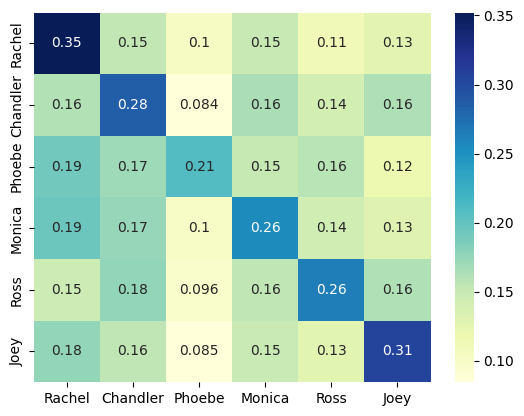

In [139]:
m = train_and_test(X=X, y=y, model=LinearSVC())

In [140]:
rachel_sentences = [
    "Oh, I like her. She's nice, you're nice... You two are a pretty nice couple. Why?",
    "Hm, you think so. Well you know what, I probably shouldn't get in the middle. 'Cause if you two did break up, I'd want you to be my concubine.",
    "Really.",
    "Okay. I-I so don't hear that. Honey I-I love these stories. But I gotta go to work. so bye. Have a great first day.",
    "I put those water reports in the right order. And I put a transparency host for, umm, I put...I do whatever the hell he tells me to do.",
    "that's true. that's true. I'm a waitress...",
    "I know central perk starts with C...",
    "Oh thank you. you are so sweet.  I'll call you.",
]


not_rachel_sentences = [
    "Hey Ross, Monica is amazing! She's such a great sister and friend. She's organized, caring, and always there for everyone. I'm so lucky to have her in my life. What do you think?",
    "Oh, really? Do you think something's going on between them? They have always been close, but I never really thought about them as a couple. What makes you think that?",
    "Oh, Joey, I understand why you might think that, but I don't think there's anything going on between Monica and Chandler. They are just really good friends. Maybe you should talk to Monica about how you're feeling. Communication is key in situations like this.",
    "I haven't noticed anything, but I'll pay more attention. Maybe they are just going through something. But I still think it's best to have a calm and honest conversation with Monica about your concerns. It's important to clear up any misunderstandings. And hey, if you need any help, I'm here for you, Joey.",
    "Thanks, Joey! Right now, I'm busy working at Central Perk, serving coffee and chatting with customers. It's busy as always, but I love it! How about you? How's auditions for acting gigs going?",
    "Oh, got it! That's nice, but I'm good for now, thanks. Maybe we can catch up over coffee some other time. I'm looking forward to it!"
]

In [141]:
vectors = tfidf_vectorizer.transform(rachel_sentences)
inp = vectors.toarray()

In [142]:
pred = m.predict(inp)
real = [0, 0, 0, 0, 0, 0, 0, 0]
print("\nTraining Accuracy score:",accuracy_score(pred, real))


Training Accuracy score: 0.25


In [143]:
vectors = tfidf_vectorizer.transform(not_rachel_sentences)
inp = vectors.toarray()

pred = m.predict(inp)
real = [0, 0, 0, 0, 0, 0]
print("\nTraining Accuracy score:",accuracy_score(pred, real))


Training Accuracy score: 0.3333333333333333
